## INF2209 COVID-19 Vaccine Twitter Topic Modelling

In [2]:
import numpy as np
import pandas as pd
import html
import re
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS

import seaborn as sns

import gensim
from gensim.utils import simple_preprocess
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
import gensim.corpora as corpora
from gensim.models import CoherenceModel
import pyLDAvis
import pyLDAvis.gensim_models


from pprint import pprint

pd.set_option('display.max_colwidth', None)

In [3]:
import warnings
warnings.filterwarnings('ignore')

## Load dataset
data obtained from Kaggle: https://www.kaggle.com/gpreda/all-covid19-vaccines-tweets

In [4]:
# load the datastet obtained from kaggle
df = pd.read_csv('vaccination_all_tweets.csv')
df.info(verbose=True)
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 222403 entries, 0 to 222402
Data columns (total 16 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   id                222403 non-null  int64 
 1   user_name         222402 non-null  object
 2   user_location     157299 non-null  object
 3   user_description  206192 non-null  object
 4   user_created      222403 non-null  object
 5   user_followers    222403 non-null  int64 
 6   user_friends      222403 non-null  int64 
 7   user_favourites   222403 non-null  int64 
 8   user_verified     222403 non-null  bool  
 9   date              222403 non-null  object
 10  text              222403 non-null  object
 11  hashtags          173757 non-null  object
 12  source            222284 non-null  object
 13  retweets          222403 non-null  int64 
 14  favorites         222403 non-null  int64 
 15  is_retweet        222403 non-null  bool  
dtypes: bool(2), int64(6), object(8)
memory

id             user_name              user_location  \
0  1340539111971516416            Rachel Roh  La Crescenta-Montrose, CA   
1  1338158543359250433           Albert Fong          San Francisco, CA   
2  1337858199140118533              eli🇱🇹🇪🇺👌                   Your Bed   
3  1337855739918835717         Charles Adler     Vancouver, BC - Canada   
4  1337854064604966912  Citizen News Channel                        NaN   

                                                                                                                                    user_description  \
0                                   Aggregator of Asian American news; scanning diverse sources 24/7/365. RT's, Follows and 'Likes' will fuel me 👩‍💻   
1            Marketing dude, tech geek, heavy metal & '80s music junkie. Fascinated by meteorology and all things in the cloud. Opinions are my own.   
2                                                                                                                                     heil, hydra 🖐☺   
3  Hosting "CharlesAdlerTonight" Global News Radio Network. Weeknights 7 Pacific-10 Eastern - Email comments/ideas to charles@charlesadlertonight.ca   
4                Citizen News Channel bringing you an alternative news source from citizen journalists that haven't sold out. Real news & real views   

          user_created  user_followers  user_friends  user_favourites  \
0  2009-04-08 17:52:46             405          1692             3247   
1  2009-09-21 15:27:30             834           666              178   
2  2020-06-25 23:30:28              10            88              155   
3  2008-09-10 11:28:53           49165          3933            21853   
4  2020-04-23 17:58:42             152           580             1473   

   user_verified                 date  \
0          False  2020-12-20 06:06:44   
1          False  2020-12-13 16:27:13   
2          False  2020-12-12 20:33:45   
3           True  2020-12-12 20:23:59   
4          False  2020-12-12 20:17:19   

                                                                                                                                           text  \
0                                             Same folks said daikon paste could treat a cytokine storm #PfizerBioNTech https://t.co/xeHhIMg1kF   
1  While the world has been on the wrong side of history this year, hopefully, the biggest vaccination effort we've ev… https://t.co/dlCHrZjkhm   
2  #coronavirus #SputnikV #AstraZeneca #PfizerBioNTech #Moderna #Covid_19 Russian vaccine is created to last 2-4 years… https://t.co/ieYlCKBr8P   
3  Facts are immutable, Senator, even when you're not ethically sturdy enough to acknowledge them. (1) You were born i… https://t.co/jqgV18kch4   
4       Explain to me again why we need a vaccine @BorisJohnson @MattHancock #whereareallthesickpeople #PfizerBioNTech… https://t.co/KxbSRoBEHq   

                                                                              hashtags  \
0                                                                   ['PfizerBioNTech']   
1                                                                                  NaN   
2  ['coronavirus', 'SputnikV', 'AstraZeneca', 'PfizerBioNTech', 'Moderna', 'Covid_19']   
3                                                                                  NaN   
4                                       ['whereareallthesickpeople', 'PfizerBioNTech']   

                source  retweets  favorites  is_retweet  
0  Twitter for Android         0          0       False  
1      Twitter Web App         1          1       False  
2  Twitter for Android         0          0       False  
3      Twitter Web App       446       2129       False  
4   Twitter for iPhone         0          0       False

In [5]:
# load the meta data and extract out fields that will be useful to our application
df = df[['user_location','date','text','hashtags']]
df = df.drop_duplicates(subset='text', keep="first")
df["clean_text"] = df["text"].str.lower()
df.reset_index(inplace=True, drop=True)

df.head()

user_location                 date  \
0  La Crescenta-Montrose, CA  2020-12-20 06:06:44   
1          San Francisco, CA  2020-12-13 16:27:13   
2                   Your Bed  2020-12-12 20:33:45   
3     Vancouver, BC - Canada  2020-12-12 20:23:59   
4                        NaN  2020-12-12 20:17:19   

                                                                                                                                           text  \
0                                             Same folks said daikon paste could treat a cytokine storm #PfizerBioNTech https://t.co/xeHhIMg1kF   
1  While the world has been on the wrong side of history this year, hopefully, the biggest vaccination effort we've ev… https://t.co/dlCHrZjkhm   
2  #coronavirus #SputnikV #AstraZeneca #PfizerBioNTech #Moderna #Covid_19 Russian vaccine is created to last 2-4 years… https://t.co/ieYlCKBr8P   
3  Facts are immutable, Senator, even when you're not ethically sturdy enough to acknowledge them. (1) You were born i… https://t.co/jqgV18kch4   
4       Explain to me again why we need a vaccine @BorisJohnson @MattHancock #whereareallthesickpeople #PfizerBioNTech… https://t.co/KxbSRoBEHq   

                                                                              hashtags  \
0                                                                   ['PfizerBioNTech']   
1                                                                                  NaN   
2  ['coronavirus', 'SputnikV', 'AstraZeneca', 'PfizerBioNTech', 'Moderna', 'Covid_19']   
3                                                                                  NaN   
4                                       ['whereareallthesickpeople', 'PfizerBioNTech']   

                                                                                                                                     clean_text  
0                                             same folks said daikon paste could treat a cytokine storm #pfizerbiontech https://t.co/xehhimg1kf  
1  while the world has been on the wrong side of history this year, hopefully, the biggest vaccination effort we've ev… https://t.co/dlchrzjkhm  
2  #coronavirus #sputnikv #astrazeneca #pfizerbiontech #moderna #covid_19 russian vaccine is created to last 2-4 years… https://t.co/ieylckbr8p  
3  facts are immutable, senator, even when you're not ethically sturdy enough to acknowledge them. (1) you were born i… https://t.co/jqgv18kch4  
4       explain to me again why we need a vaccine @borisjohnson @matthancock #whereareallthesickpeople #pfizerbiontech… https://t.co/kxbsrobehq

In [6]:
df.shape

(220583, 5)

In [7]:
print('From {} to {}'.format(df['date'].min(), df['date'].max()))

From 2020-12-12 11:55:28 to 2021-11-12 23:36:24


## Data Cleaning:

Twitter tweets contain urls, hashtags (#), mention symbols (@) and potentially html symbols besides punctuations and stop words in other text forms. 
Therefore, text cleaning involves: 
- remove html symbols
- convert html character codes to ASCII
- remove urls
- convert to lowercase
- remove all `STOPWORDS`, can add some custom stop words using nltk
- remove all punctuations including # and @

In [8]:
# clean the hashtag contents
df['hashtags'] = df['hashtags'].str.lower()

# remove symbols and punctuations
df['hashtags'] = df['hashtags'].str.replace('_',' ')
df['hashtags'] = df['hashtags'].str.replace('[^\w\s]','')
df['hashtags']

0                                                           pfizerbiontech
1                                                                      NaN
2         coronavirus sputnikv astrazeneca pfizerbiontech moderna covid 19
3                                                                      NaN
4                                  whereareallthesickpeople pfizerbiontech
                                        ...                               
220578                             urban bengaluru covidvaccine covishield
220579                                sputnik sputnikv russiancovidvaccine
220580                              bbmp bengaluru covidvaccine covishield
220581                             urban bengaluru covidvaccine covishield
220582                             urban bengaluru covidvaccine covishield
Name: hashtags, Length: 220583, dtype: object

In [9]:
# convert html character codes to ASCII
df['clean_text'] = df['clean_text'].apply(lambda x: html.unescape(x))

In [10]:
# remove urls
df['clean_text'] = df['clean_text'].apply(lambda x: re.sub(r"http\S+", "", x))

In [11]:
# remove stop words
stop = stopwords.words('english')
df['clean_text'] = df['clean_text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

In [12]:
# remove all special characters including #, @, and emojis, only keep keywords after hashtags and mentions
df['clean_text'] = df['clean_text'].apply(lambda x: x.replace('...',' '))
df['clean_text'] = df['clean_text'].apply(lambda x: x.replace('/',' '))
df['clean_text'] = df['clean_text'].apply(lambda x: x.replace('_',' '))
df['clean_text'] = df['clean_text'].str.replace('[^\w\s]','')

In [13]:
df['text']

0                                                       Same folks said daikon paste could treat a cytokine storm #PfizerBioNTech https://t.co/xeHhIMg1kF
1            While the world has been on the wrong side of history this year, hopefully, the biggest vaccination effort we've ev… https://t.co/dlCHrZjkhm
2            #coronavirus #SputnikV #AstraZeneca #PfizerBioNTech #Moderna #Covid_19 Russian vaccine is created to last 2-4 years… https://t.co/ieYlCKBr8P
3            Facts are immutable, Senator, even when you're not ethically sturdy enough to acknowledge them. (1) You were born i… https://t.co/jqgV18kch4
4                 Explain to me again why we need a vaccine @BorisJohnson @MattHancock #whereareallthesickpeople #PfizerBioNTech… https://t.co/KxbSRoBEHq
                                                                               ...                                                                       
220578    45+ #URBAN #Bengaluru #CovidVaccine Availability for 04/11 at 09:3

In [14]:
df['clean_text']

0                                              folks said daikon paste could treat cytokine storm pfizerbiontech
1                                     world wrong side history year hopefully biggest vaccination effort weve ev
2         coronavirus sputnikv astrazeneca pfizerbiontech moderna covid 19 russian vaccine created last 24 years
3                                 facts immutable senator even ethically sturdy enough acknowledge them 1 born i
4                          explain need vaccine borisjohnson matthancock whereareallthesickpeople pfizerbiontech
                                                           ...                                                  
220578       45 urban bengaluru covidvaccine availability 04 11 0930am free slots 0 paid slots covishield  dose1
220579            covid19 sputnik jab proves ineffective resistant russians sputnik sputnikv russiancovidvaccine
220580         1844 bbmp bengaluru covidvaccine availability 04 11 0900am free slots covishield 

In [15]:
# convert date to year-month
df['date'] = pd.to_datetime(df['date']).dt.date

## Exploratory Data Analysis

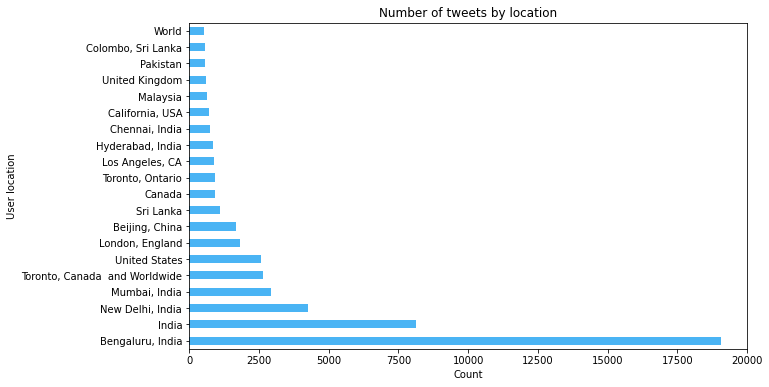

In [20]:
region_map = {'New Delhi':'New Delhi, India', 'Mumbai': 'Mumbai, India', 'London': 'London, England', 'Beijing':'Beijing, China', 'USA':'United States'}
df['user_location'] = df['user_location'].map(region_map).fillna(df['user_location'])

# Visualize tweet count vs location
plt.figure(figsize=(10,6))
df['user_location'].value_counts().nlargest(20).plot(kind='barh', color='#1DA1F2', alpha=0.8)
plt.xlabel('Count')
plt.ylabel('User location')
plt.title('Number of tweets by location')
plt.show()

### Vaccine-related tweets by month

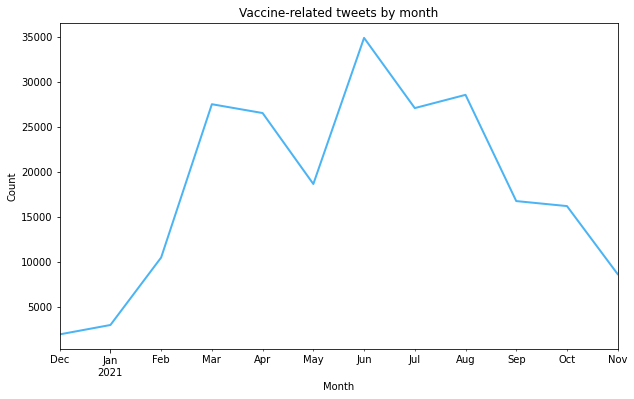

In [21]:
df['date_yrmo'] = pd.to_datetime(df['date']).dt.to_period('M')

yrmo_twt = df.groupby('date_yrmo')['date_yrmo'].count()
yrmo_twt.plot.line(figsize=(10,6),label='month', color='#1DA1F2', alpha=0.8, lw=2)
plt.xlabel('Month')
plt.ylabel('Count')
plt.title('Vaccine-related tweets by month')
plt.xlim('2020-12','2021-11')
plt.show()

### Word Cloud: visualize the trending words
### Hashtag key words

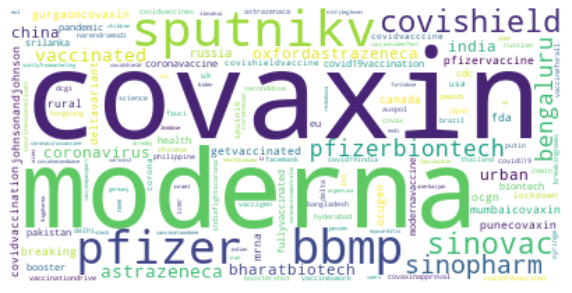

In [16]:
# create a word cloud to visualize the most frequent key words in the hashtags
plt.figure(figsize=(10,8))
text = " ".join(tags for tags in df['hashtags'].dropna())
stopwords = set(STOPWORDS)
stopwords.update(["vaccine",'vaccines','vaccination','covid19','covid','covid_19','covidvaccine','covid19vaccine'])
wordcloud = WordCloud(stopwords=stopwords, background_color="white", collocations=False).generate(text)   # false collocations remove repetitive words in cloud
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

### Combine vaccine namings to ensure consistency

In [17]:
df['clean_text'] = df['clean_text'].str.replace('pfizerbiontech','pfizer')
df['clean_text'] = df['clean_text'].str.replace('pfizervaccine','pfizer')
df['clean_text'] = df['clean_text'].str.replace('ocugen','ocgn')
df['clean_text'] = df['clean_text'].str.replace('sputnikvaccine','sputnik')
df['clean_text'] = df['clean_text'].str.replace('sputnik v','sputnik')
df['clean_text'] = df['clean_text'].str.replace('sputnikv','sputnik')
df['clean_text'] = df['clean_text'].str.replace('oxfordastrazeneca','astrazeneca')

### Vaccine tweets key phrases

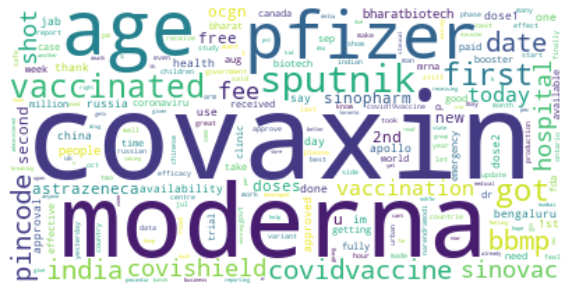

In [18]:
# create a word cloud to visualize the most frequent key words in the vaccine tweets
plt.figure(figsize=(10,8))
text = " ".join(twt for twt in df['clean_text'])
stopwords = set(STOPWORDS)
stopwords.update(["vaccine",'vaccines','dose','covid','covid19','ages','slots'])
wordcloud = WordCloud(stopwords=stopwords, background_color="white", collocations=False).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

### Visualize trending 3-grams

In [18]:
from sklearn.feature_extraction.text import CountVectorizer

def get_top_ngram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    fwords_freq = []
    for i in words_freq:
        temp = 0
        for j in i[0].split():
            if j in stop:
                temp += 1
        if temp != len(i[0].split()):
            fwords_freq.append(i)
    words_freq = fwords_freq
    words_freq =sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:30]


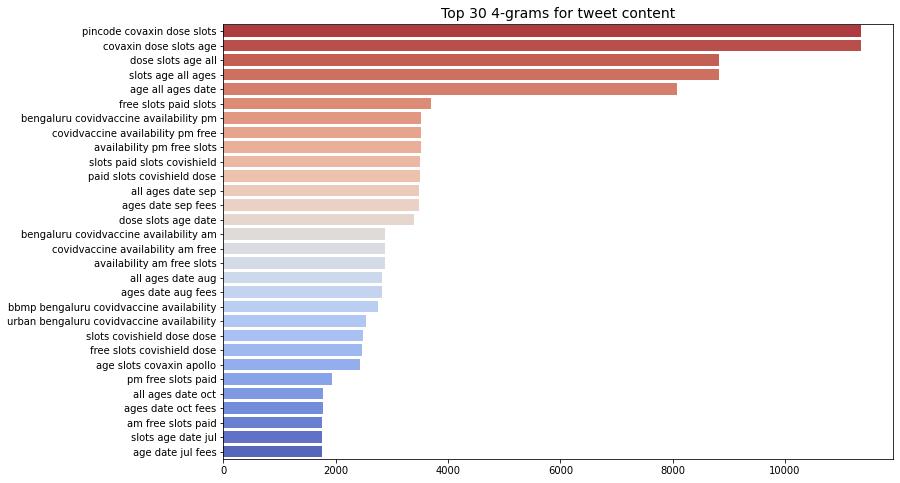

In [19]:
plt.figure(figsize=(12,8))
top_n_trigrams = get_top_ngram(df.clean_text.str.replace('\d+', ''), 4)[:30]    # remove numbers in key words

x, y = map(list, zip(*top_n_trigrams)) 

sns.barplot(x=y, y=x, palette='coolwarm_r')
plt.title('Top 30 4-grams for tweet content', fontsize=14)
plt.show()

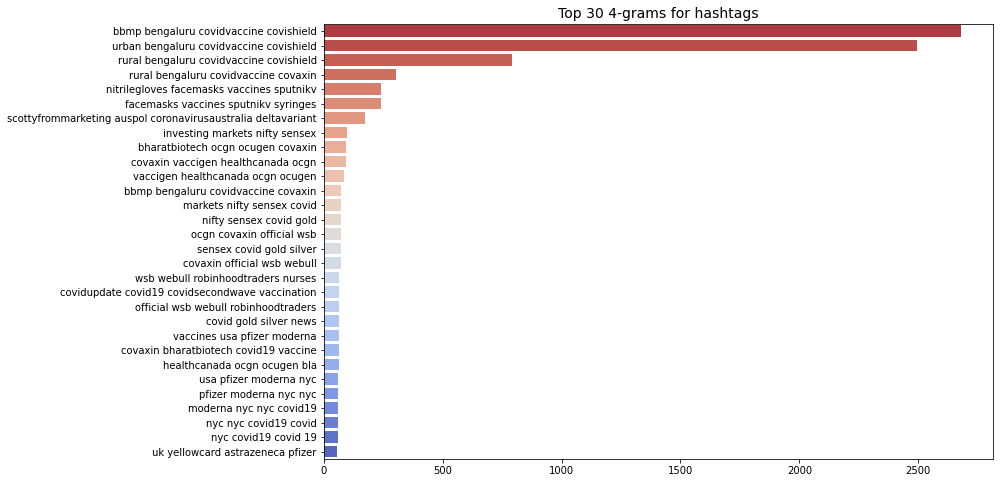

In [20]:
plt.figure(figsize=(12,8))
top_n_trigrams = get_top_ngram(df.hashtags.dropna(), 4)[:30]

x, y = map(list, zip(*top_n_trigrams)) 

sns.barplot(x=y, y=x, palette='coolwarm_r')
plt.title('Top 30 4-grams for hashtags', fontsize=14)
plt.show()

### Sentiment Analysis: Polarity distribution
VADER (Valence Aware Dictionary and sEntiment Reasoner) is a lexicon and rule-based sentiment analysis tool that is specifically attuned to sentiments expressed in social media. Vader is optimized for social media data and can yield good results when used with data from Twitter.
<br> The [polarity score](https://github.com/cjhutto/vaderSentiment#about-the-scoring) is an aggregate measure of for negative (<= -0.05), neutral, and positive (>=0.05) sentiment ranging from -1 to 1. </br> 

In [32]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
#nltk.download('vader_lexicon')

# Create a SentimentIntensityAnalyzer object
sid = SentimentIntensityAnalyzer()

def sentiment_scores(sentence):
    # polarity_scores method of SentimentIntensityAnalyzer
    # object gives a sentiment dictionary, which contains pos, neg, neu, and compound scores.
    sentiment_dict = sid.polarity_scores(sentence)
    sentiment_score = sentiment_dict['compound']
    return sentiment_score

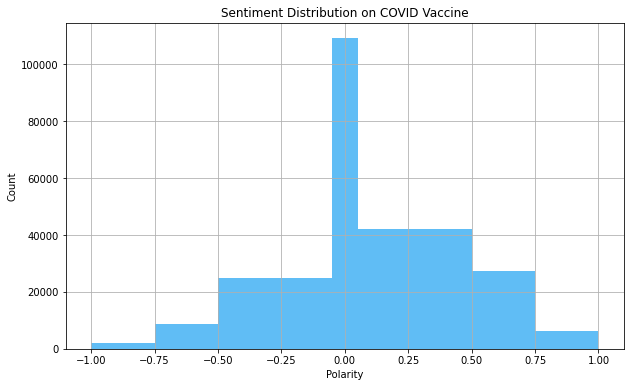

In [33]:
plt.figure(figsize=(10,6))
df['sentiment_score'] = df['text'].apply(lambda x: sentiment_scores(x))
df['sentiment_score'].hist(bins=[-1,-0.75,-0.5,-0.05,0.05,0.5,0.75,1], color='#1DA1F2', alpha=0.7)
plt.title('Sentiment Distribution on COVID Vaccine')
plt.xlabel('Polarity')
plt.ylabel('Count')
plt.show()

## Topic Model 1: Latent Dirichlet Allocation (LDA)
code adapted from [Topic Modeling with Gensim (Python)](https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/#15visualizethetopicskeywords)

### Tokenization: Create Bigram and Trigram Models

In [19]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data = df.clean_text.values.tolist()
data_words = list(sent_to_words(data))

In [20]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[5]]])

['anyone', 'useful', 'advice', 'guidance', 'whether', 'covid', 'vaccine', 'safe', 'whilst', 'breastfeeding']


In [21]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['covid', 'covid19','vaccine','vaccines','covidvaccine','use','ages','slots'])

def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

# Lemmatize the documents
def lemm(texts):
    return [[WordNetLemmatizer().lemmatize(word, pos='v') for word in doc] for doc in texts]

In [22]:
# remove stop words in addition to the normal english stopwords
data_words = remove_stopwords(data_words)

# form bigrams
data_words = make_bigrams(data_words)

# Lemmatization
data_words = lemm(data_words)
print(data_words[5:][0][:30])

['anyone', 'useful', 'advice', 'guidance', 'whether', 'safe', 'whilst', 'breastfeed']


### Create the dictionary and corpus needed for Topic Modeling

In [23]:
# Create Dictionary
id2word = corpora.Dictionary(data_words)
# Filter out words that occur less than 20 documents, or more than 50% of the documents
id2word.filter_extremes(no_below=20, no_above=0.5)

# Create Corpus
texts = data_words
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[5:][0][:30])

[(32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, 1), (38, 1), (39, 1)]


### Find Optimal Number of Topics for LDA: Coherence vs. Jaccard

In [24]:
# Jaccard similarity function
def jaccard_similarity(topic_1, topic_2):
    """
    Jaccard similarity:
    - Calculate the degree of topic overlap
    - J(A,B) = (A ∩ B)/(A ∪ B)
    - Goal is low Jaccard scores for coverage of the diverse elements
    """
    intersection = set(topic_1).intersection(set(topic_2))
    union = set(topic_1).union(set(topic_2))
                    
    return float(len(intersection))/float(len(union))

In [25]:
def coherence_jaccard_calculate(topic_model, num_topics, num_keywords):
    '''
    Calculate topic coherence and jaccard score for each topic number.
    '''
    models_dict = {}
    topics_dict = {}
    for i in num_topics:
        models_dict[i] = topic_model(corpus=corpus,
                             id2word=id2word,
                             num_topics=i,
                             random_state=97116)
        shown_topics = models_dict[i].show_topics(num_topics=i, 
                                                 num_words=num_keywords,
                                                 formatted=False)
        topics_dict[i] = [[word[0] for word in topic[1]] for topic in shown_topics]
        
    # Coherence matrix using c_v method
    coherences = [CoherenceModel(model=models_dict[i], texts=data_words, dictionary=id2word, coherence='c_v').get_coherence()\
                  for i in num_topics[:-1]]
    
    # derive the mean stability (jaccard similarity) across topics by considering the next topic:
    model_stability = {}
    for i in range(0, len(num_topics)-1):
        jaccard_sims = []
        for t1, topic1 in enumerate(topics_dict[num_topics[i]]): 
            sims = []
            for t2, topic2 in enumerate(topics_dict[num_topics[i+1]]): 
                sims.append(jaccard_similarity(topic1, topic2))    
            jaccard_sims.append(sims)    
        model_stability[num_topics[i]] = jaccard_sims
    mean_stabilities = [np.array(model_stability[i]).mean() for i in num_topics[:-1]]
    return coherences, mean_stabilities

In [25]:
from gensim.models import LdaMulticore as LdaModel

num_topics = list(range(16)[2:])
coherences_lda1, jaccard_lda1 = coherence_jaccard_calculate(topic_model=LdaModel, num_topics = num_topics, num_keywords=15)
print('Topic coherence for LDA: ', coherences_lda1)
print('Average Topic Overlap for LDA: ', jaccard_lda1)

Topic coherence for LDA:  [0.31529213212704366, 0.3100270982803232, 0.28687347339240704, 0.2712432031606792, 0.3118834953432176, 0.3152523849801002, 0.29092003689216894, 0.28906926364607854, 0.28365057373539443, 0.26844633037800186, 0.27812505094668444, 0.28240720972651784, 0.28963591664162175]
Average Topic Overlap for LDA:  [0.3942918192918193, 0.338923082110254, 0.31404033641161794, 0.31265219861127785, 0.269954093237672, 0.25339101690477017, 0.2435601470006868, 0.2336033602249759, 0.2358908754321683, 0.2331509473299769, 0.2282375207390596, 0.2239906878665356, 0.21270556286024062]


In [26]:
from gensim.models import LdaMulticore as LdaModel

num_topics = list(range(16)[2:])
coherences_lda1, jaccard_lda1 = coherence_jaccard_calculate(topic_model=LdaModel, num_topics = num_topics, num_keywords=15)
print('Topic coherence for LDA: ', coherences_lda1)
print('Average Topic Overlap for LDA: ', jaccard_lda1)

Topic coherence for LDA:  [0.24675322228567764, 0.27374013041523226, 0.30226737931729697, 0.2640450217995013, 0.28254814796327804, 0.29605573207064245, 0.3122573094896486, 0.2949700835327185, 0.2806476247375235, 0.302069007436839, 0.31479231303257676, 0.32681925095169706, 0.30047890212226436]
Average Topic Overlap for LDA:  [0.3471757710888146, 0.35560370055254964, 0.31250701430604516, 0.3003385139062888, 0.25276142787103695, 0.246933175270663, 0.23088040897431966, 0.21082457717270345, 0.21220504670421456, 0.2010376562697837, 0.18976820963607102, 0.19201891565451262, 0.19646033353027548]


### Optimal number of topics: where the difference between Coherence and Jaccard Similarity is maximized
code adapted from [stackoverflow](https://stackoverflow.com/questions/32313062/what-is-the-best-way-to-obtain-the-optimal-number-of-topics-for-a-lda-model-usin)

In [27]:
def coherence_jaccard_plot(coherences, mean_stabilities):
    plt.figure(figsize=(10,8))
    ax = sns.lineplot(x=num_topics[:-1], y=mean_stabilities, label='Average Topic Overlap')
    ax = sns.lineplot(x=num_topics[:-1], y=coherences, label='Topic Coherence')

    y_max = max(max(mean_stabilities), max(coherences)) + (0.10 * max(max(mean_stabilities), max(coherences)))
    ax.set_ylim([0, y_max])
    ax.set_xlim([1, num_topics[-1]-1])

    ax.axes.set_title('Model Metrics per Number of Topics', fontsize=20)
    ax.set_ylabel('Metric Level', fontsize=14)
    ax.set_xlabel('Number of Topics', fontsize=14)
    plt.legend(fontsize=14)
    plt.show()   

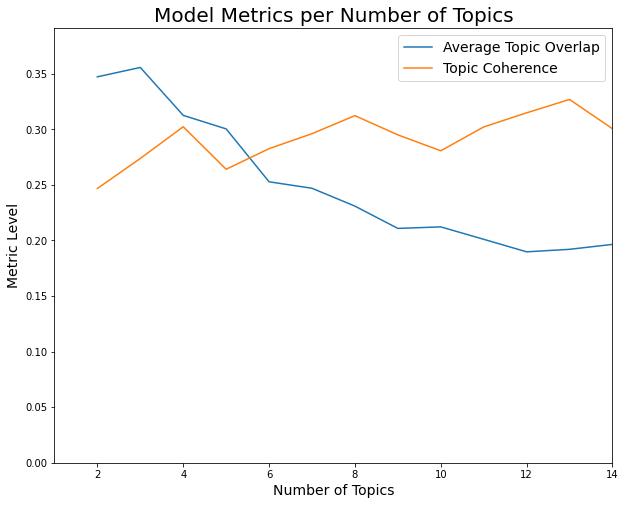

In [28]:
coherences = coherences_lda1
mean_stabilities = jaccard_lda1
coherence_jaccard_plot(coherences, mean_stabilities)

The best LDA model has 8 topics.

In [33]:
# number of topics
num_topics = 7

# Build the best LDA model
best_model_lda1 = gensim.models.LdaMulticore(corpus=corpus,
                                      id2word=id2word,
                                      num_topics=num_topics,
                                      random_state=97116)

In [34]:
pprint(best_model_lda1.show_topics(num_topics=7,num_words=20))

[(0,
  '0.048*"moderna" + 0.040*"pfizer" + 0.039*"dose" + 0.023*"aug" + '
  '0.014*"sinovac" + 0.008*"say" + 0.008*"vaccination" + 0.007*"covaxin" + '
  '0.007*"get" + 0.006*"nd" + 0.006*"st" + 0.006*"sputnik" + 0.006*"health" + '
  '0.006*"booster" + 0.006*"million" + 0.006*"people" + 0.006*"coronavirus" + '
  '0.006*"first" + 0.006*"us" + 0.005*"case"'),
 (1,
  '0.112*"covaxin" + 0.111*"age" + 0.060*"date" + 0.059*"dose" + 0.052*"bbmp" '
  '+ 0.040*"fee" + 0.032*"rs" + 0.023*"sep" + 0.022*"hospital" + 0.015*"india" '
  '+ 0.009*"moderna" + 0.007*"today" + 0.005*"mohfw" + 0.004*"pfizer" + '
  '0.004*"th" + 0.004*"receive" + 0.004*"sputnik" + 0.004*"get" + '
  '0.004*"sinovac" + 0.004*"first"'),
 (2,
  '0.099*"covaxin" + 0.096*"dose" + 0.037*"free" + 0.037*"covishield" + '
  '0.034*"availability" + 0.028*"ocgn" + 0.023*"pm" + 0.020*"pay" + '
  '0.018*"hospital" + 0.017*"moderna" + 0.014*"bharatbiotech" + '
  '0.014*"bengaluru" + 0.013*"urban_bengaluru" + 0.011*"take" + '
  '0.011*"vacc

### Interactive report interface

In [35]:
pyLDAvis.enable_notebook()
vis_best1 = pyLDAvis.gensim_models.prepare(best_model_lda1, corpus, id2word)
vis_best1

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6      0.134152 -0.075587       1        1  21.266845
4     -0.010819  0.133928       2        1  16.980856
5      0.091681 -0.001769       3        1  13.214657
0      0.080021  0.038406       4        1  12.837938
2     -0.085548 -0.160573       5        1  12.268474
1     -0.221899  0.025065       6        1  11.720196
3      0.012414  0.040530       7        1  11.711034, topic_info=               Term          Freq         Total Category  logprob  loglift
503             age  22342.000000  22342.000000  Default  30.0000  30.0000
2356        covaxin  70280.000000  70280.000000  Default  29.0000  29.0000
5231        pincode  14779.000000  14779.000000  Default  28.0000  28.0000
1581           date  12664.000000  12664.000000  Default  27.0000  27.0000
5651           bbmp  10116.000000  10116.000000  Default  26.0000  26.0000
...             ...           ...           ...      ...      ...      ...
98        vaccinate   1177.058521  16021.757250   Topic7  -5.0935  -0.4663
2            pfizer   1328.092038  26797.475915   Topic7  -4.9727  -0.8599
518           india   1051.495781  10790.558929   Topic7  -5.2063  -0.1838
17      astrazeneca    951.230992   7296.159519   Topic7  -5.3065   0.1073
683   bharatbiotech    904.671027   6482.292718   Topic7  -5.3567   0.1754

[571 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
6417      4  0.027202  aarthi_scan
6417      6  0.878229  aarthi_scan
6417      7  0.093263  aarthi_scan
5354      4  0.975304   acceptable
5367      1  0.998277  adolescents
...     ...       ...          ...
3880      2  0.006220          yrs
3880      3  0.942264          yrs
3880      4  0.009329          yrs
3880      6  0.027988          yrs
3880      7  0.012439          yrs

[1587 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 5, 6, 1, 3, 2, 4])

In [36]:
pyLDAvis.save_html(vis_best1, './ldatopics_vis1.html')

### Give vaccine names a uniformed alias 'vaccine name' before modeling
To prevent various vaccine names from occupying the key word spots in the topic list.

In [37]:
vaccines = ['pfizer','pfizerbiontech','moderna','covaxin','sputnik','covishield','astrazeneca','sinovac','sinopharm']
df['clean_text_renamed'] = df['clean_text']
for vaccine in vaccines:
    df['clean_text_renamed'] = df['clean_text_renamed'].str.replace(vaccine,'vaccine_name')

In [38]:
df['clean_text_renamed']

0                                                        folks said daikon paste could treat cytokine storm vaccine_name
1                                             world wrong side history year hopefully biggest vaccination effort weve ev
2         coronavirus vaccine_name vaccine_name vaccine_name vaccine_name covid 19 russian vaccine created last 24 years
3                                         facts immutable senator even ethically sturdy enough acknowledge them 1 born i
4                                    explain need vaccine borisjohnson matthancock whereareallthesickpeople vaccine_name
                                                               ...                                                      
220578             45 urban bengaluru covidvaccine availability 04 11 0930am free slots 0 paid slots vaccine_name  dose1
220579      covid19 vaccine_name jab proves ineffective resistant russians vaccine_name vaccine_name russiancovidvaccine
220580               1844 bbmp b

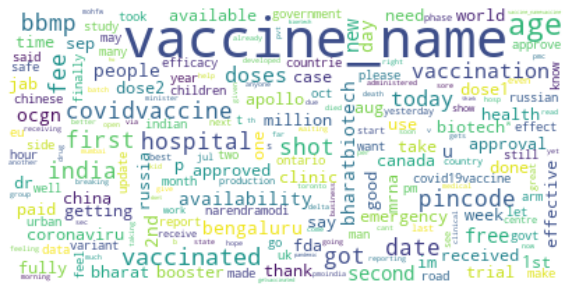

In [39]:
# create a word cloud to visualize the most frequent key words in the vaccine tweets
plt.figure(figsize=(10,8))
text = " ".join(twt for twt in df['clean_text_renamed'])
stopwords = set(STOPWORDS)
stopwords.update(["vaccine",'vaccines','dose','covid','covid19','ages','slots'])
wordcloud = WordCloud(stopwords=stopwords, background_color="white", collocations=False).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## Rebuild LDA model after renaming vaccines

In [40]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data = df.clean_text.values.tolist()
data_words = list(sent_to_words(data))

In [41]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[5]]])

['anyone', 'useful', 'advice', 'guidance', 'whether', 'covid', 'vaccine', 'safe', 'whilst', 'breastfeeding']


In [42]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['covid', 'covid19','vaccine','covidvaccine','vaccines','shots','use','ages','slots'])

def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

# Lemmatize the documents
def lemm(texts):
    return [[WordNetLemmatizer().lemmatize(word, pos='v') for word in doc] for doc in texts]

In [43]:
# remove stop words in addition to the normal english stopwords
data_words = remove_stopwords(data_words)

# form bigrams
data_words = make_bigrams(data_words)

# Lemmatization
data_words = lemm(data_words)
print(data_words[5:][0][:30])

['anyone', 'useful', 'advice', 'guidance', 'whether', 'safe', 'whilst', 'breastfeed']


In [44]:
# Create Dictionary
id2word = corpora.Dictionary(data_words)
# Filter out words that occur less than 20 documents, or more than 50% of the documents
id2word.filter_extremes(no_below=20, no_above=0.5)

# Create Corpus
texts = data_words
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[5:][0][:30])

[(32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, 1), (38, 1), (39, 1)]


In [45]:
from gensim.models import LdaMulticore as LdaModel

num_topics = list(range(16)[2:])
coherences_lda2, jaccard_lda2 = coherence_jaccard_calculate(topic_model=LdaModel, num_topics = num_topics, num_keywords=15)
print('Topic coherence for LDA with vaccine alias: ', coherences_lda2)
print('Average Topic Overlap with vaccine alias: ', jaccard_lda2)

Topic coherence for LDA with vaccine alias:  [0.33717113840485674, 0.2846168205511292, 0.2783167743331636, 0.29558780749760016, 0.30025859635283986, 0.3003948310940007, 0.29538922870769246, 0.2840274086688182, 0.267319490748669, 0.27919857545465576, 0.28711027990761034, 0.2790876566482803, 0.2941137754940949]
Average Topic Overlap with vaccine alias:  [0.45055704099821753, 0.3264809714298205, 0.30992757097142404, 0.2885844658553892, 0.2757180812440307, 0.2563895570516873, 0.23205470978926065, 0.24255716801296956, 0.2378384934499929, 0.22130588097513867, 0.21142795462801822, 0.20841110248740444, 0.20483754959986442]


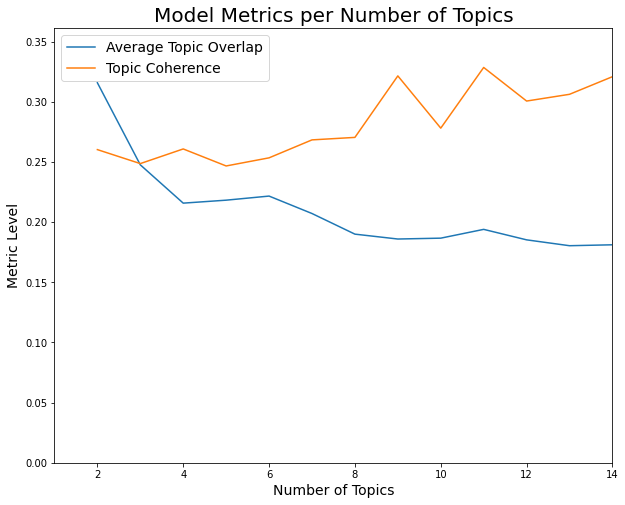

In [44]:
coherences = coherences_lda2
mean_stabilities = jaccard_lda2
coherence_jaccard_plot(coherences, mean_stabilities)

The best LDA model has 9 topics.

In [45]:
# number of topics
num_topics = 9

# Build the best LDA model
best_model_lda2 = gensim.models.LdaMulticore(corpus=corpus,
                                      id2word=id2word,
                                      num_topics=num_topics,
                                      random_state=97116)

In [46]:
pprint(best_model_lda2.show_topics(num_topics=9,num_words=20))

[(0,
  '0.058*"vaccine_name" + 0.034*"ocgn" + 0.021*"apollo" + '
  '0.016*"bharatbiotech" + 0.012*"say" + 0.008*"news" + '
  '0.008*"ocgn_vaccine_name" + 0.007*"like" + 0.006*"world" + 0.006*"take" + '
  '0.005*"good" + 0.005*"study" + 0.005*"effective" + 0.005*"would" + '
  '0.005*"get" + 0.005*"people" + 0.004*"dose" + '
  '0.004*"vaccine_name_vaccine_name" + 0.004*"new" + 0.004*"best"'),
 (1,
  '0.041*"vaccine_name" + 0.031*"dose_vaccine_name" + 0.030*"dose" + '
  '0.026*"first" + 0.019*"receive" + 0.018*"doses_vaccine_name" + '
  '0.015*"second" + 0.013*"million" + 0.010*"nd" + 0.010*"take" + 0.009*"get" '
  '+ 0.008*"coronavirus" + 0.008*"health" + 0.008*"china" + '
  '0.007*"vaccinated_vaccine_name" + 0.007*"vaccinate" + 0.007*"people" + '
  '0.007*"today" + 0.005*"say" + 0.005*"arrive"'),
 (2,
  '0.095*"fee" + 0.074*"bbmp" + 0.058*"rs" + 0.049*"vaccine_name" + '
  '0.037*"dose" + 0.032*"aug" + 0.020*"hospital" + '
  '0.016*"hospital_vaccine_name" + 0.014*"vaccination" + 0.007*"c

### Interactive report interface

In [47]:
pyLDAvis.enable_notebook()
vis_best = pyLDAvis.gensim_models.prepare(best_model_lda2, corpus, id2word)
vis_best

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5     -0.019642  0.157165       1        1  14.518085
8     -0.124999 -0.039874       2        1  12.568057
0     -0.058826  0.112481       3        1  11.829774
3     -0.036757 -0.163684       4        1  11.713074
6      0.240402 -0.011415       5        1  11.385696
1     -0.033595 -0.064175       6        1  10.580747
4     -0.089454 -0.030792       7        1   9.794587
7     -0.020208  0.056517       8        1   9.104313
2      0.143080 -0.016223       9        1   8.505667, topic_info=         Term          Freq         Total Category  logprob  loglift
213      dose  47775.000000  47775.000000  Default  30.0000  30.0000
517       age  20369.000000  20369.000000  Default  29.0000  29.0000
2302      fee  12676.000000  12676.000000  Default  28.0000  28.0000
6101     bbmp   9874.000000   9874.000000  Default  27.0000  27.0000
1651     date  11281.000000  11281.000000  Default  26.0000  26.0000
...       ...           ...           ...      ...      ...      ...
88    receive    479.258218   5345.244779   Topic9  -5.5928   0.0527
517       age    559.271508  20369.502385   Topic9  -5.4384  -1.1307
521      free    396.984183   8788.450087   Topic9  -5.7812  -0.6329
62      first    353.245855  12050.491106   Topic9  -5.8979  -1.0653
122      make    328.194929   4566.210915   Topic9  -5.9714  -0.1684

[739 rows x 6 columns], token_table=      Topic      Freq              Term
term                                   
6876      5  0.907124       aarthi_scan
6876      9  0.088500       aarthi_scan
3866      6  0.971719          abudhabi
5765      5  0.983026        acceptable
4379      3  0.027259  add_vaccine_name
...     ...       ...               ...
4152      8  0.007610               yrs
4152      9  0.669662               yrs
2962      4  0.014153           yrs_old
2962      8  0.948265           yrs_old
2962      9  0.028306           yrs_old

[2407 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 9, 1, 4, 7, 2, 5, 8, 3])

In [48]:
pyLDAvis.save_html(vis_best, './ldatopics_vis2.html')

Based on the model output (coherence jaccard plot & topic cluster visualization), the original LDA model produces a more interpretable and thus a better topic result. It is possible that the vaccine name alias concealed some information that could signal iindividual traits for different brands of vaccine (e.g. country of manufacturer, user location, domesic situation, and government policy).

## Topic Model 2: NMF Non-Negative Matrix Factorization

NMF decomposes high-dimensional vectors into a lower-dimensional representation where the coefficients of these lower dimensional vectors are non-negative. 

In [85]:
data = df.clean_text.values.tolist()
data_words = list(sent_to_words(data))

In [86]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [87]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['covid', 'vaccine','vaccines','covidvaccine','use','ages','slots'])

def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

# Lemmatize the documents
def lemm(texts):
    return [[WordNetLemmatizer().lemmatize(word, pos='v') for word in doc] for doc in texts]

In [88]:
# remove stop words in addition to the normal english stopwords
data_words = remove_stopwords(data_words)

# form bigrams
data_words = make_bigrams(data_words)

# Lemmatization
data_words = lemm(data_words)
print(data_words[5:][0][:30])

['anyone', 'useful', 'advice', 'guidance', 'whether', 'safe', 'whilst', 'breastfeed']


### Create the dictionary and corpus needed for Topic Modeling

In [89]:
# Create Dictionary
id2word = corpora.Dictionary(data_words)
# Filter out words that occur less than 20 documents, or more than 50% of the documents
id2word.filter_extremes(no_below=20, no_above=0.5)

# Create Corpus
texts = data_words
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[5:][0][:30])

[(32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, 1), (38, 1), (39, 1)]


In [90]:
from gensim.models.nmf import Nmf
num_topics = list(range(16)[2:])

coherences_nmf, jaccard_nmf = coherence_jaccard_calculate(topic_model=Nmf, num_topics = num_topics, num_keywords=15)
print('Topic coherence for NMF: ', coherences_nmf)
print('Average Topic Overlap for NMF: ', jaccard_nmf)

Topic coherence for NMF:  [0.2503786016732829, 0.2850968056761075, 0.3076826009744926, 0.3421458650797324, 0.34395074791571956, 0.32390234022550135, 0.3134616656532341, 0.32705980693798786, 0.3563782322303675, 0.3279387623956101, 0.3465965748752832, 0.3537933443022127, 0.35435717510464665]
Average Topic Overlap for NMF:  [0.3661174351963825, 0.2345819101727332, 0.19162882531165493, 0.1827298717359569, 0.1719042371162574, 0.14742997269501876, 0.13424085315621168, 0.12318211729998484, 0.11769216891927667, 0.118728188586436, 0.10247692565247024, 0.09741831908801105, 0.09884309590670363]


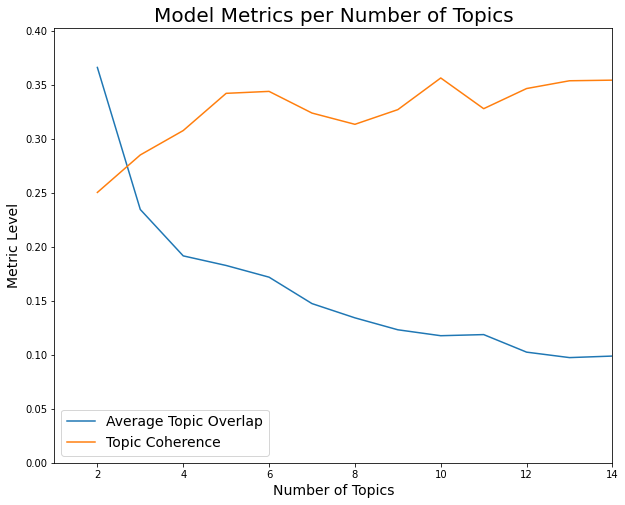

In [91]:
coherences = coherences_nmf
mean_stabilities = jaccard_nmf
coherence_jaccard_plot(coherences, mean_stabilities)

According to the NMF result, the optimal number of topics would be 6 or 10, where the topic coherence is maximized within a single topic among high-scoring words and the Jaccard similarity is declining to the lowest point. 

In [92]:
# number of topics
num_topics = 6

# Build the best NMF model
best_model_nmf = Nmf(corpus=corpus,
                id2word=id2word,
                num_topics=num_topics,
                random_state=97116)

In [93]:
pprint(best_model_nmf.show_topics(num_topics=6,num_words=20))

[(0,
  '0.190*"moderna" + 0.029*"shoot" + 0.024*"get" + 0.015*"first" + '
  '0.014*"second" + 0.011*"vaccinate" + 0.010*"today" + 0.009*"im" + '
  '0.008*"nd" + 0.008*"booster" + 0.008*"mrna" + 0.007*"feel" + 0.006*"one" + '
  '0.006*"say" + 0.006*"go" + 0.005*"like" + 0.005*"arm" + 0.005*"do" + '
  '0.005*"day" + 0.005*"thank"'),
 (1,
  '0.226*"pfizer" + 0.051*"covishield" + 0.024*"moderna" + 0.011*"us" + '
  '0.011*"vaccination" + 0.010*"study" + 0.010*"biontech" + 0.009*"effective" '
  '+ 0.008*"fda" + 0.008*"mrna" + 0.007*"free" + 0.007*"availability" + '
  '0.006*"say" + 0.006*"pay" + 0.005*"india" + 0.005*"coronavirus" + '
  '0.005*"approve" + 0.004*"cdc" + 0.004*"new" + 0.004*"show"'),
 (2,
  '0.193*"get" + 0.058*"vaccinate" + 0.043*"pfizer" + 0.020*"today" + '
  '0.013*"thank" + 0.013*"jab" + 0.011*"people" + 0.011*"shoot" + '
  '0.010*"first" + 0.009*"fully" + 0.009*"nd" + 0.008*"sinovac" + '
  '0.008*"second" + 0.007*"im" + 0.007*"st" + 0.007*"go" + 0.007*"approval" + '
  '0.

In [94]:
# number of topics
num_topics = 10

# Build the best NMF model
best_model_nmf2 = Nmf(corpus=corpus,
                id2word=id2word,
                num_topics=num_topics,
                random_state=97116)

In [95]:
pprint(best_model_nmf2.show_topics(num_topics=10,num_words=20))

[(0,
  '0.178*"sputnik" + 0.032*"india" + 0.032*"say" + 0.024*"vaccinate" + '
  '0.013*"approve" + 0.013*"russia" + 0.012*"russian" + 0.011*"russias" + '
  '0.006*"emergency" + 0.006*"available" + 0.005*"news" + 0.005*"production" + '
  '0.005*"produce" + 0.005*"fully" + 0.005*"covishield" + 0.005*"health" + '
  '0.005*"rdif" + 0.005*"eu" + 0.004*"dr_reddys" + 0.004*"coronavirus"'),
 (1,
  '0.280*"get" + 0.045*"vaccinate" + 0.033*"today" + 0.028*"shoot" + '
  '0.020*"second" + 0.014*"nd" + 0.011*"im" + 0.011*"jab" + 0.009*"st" + '
  '0.008*"go" + 0.007*"finally" + 0.007*"approval" + 0.007*"yesterday" + '
  '0.006*"thank" + 0.006*"feel" + 0.006*"booster" + 0.005*"let" + '
  '0.005*"please" + 0.004*"like" + 0.004*"one"'),
 (2,
  '0.123*"people" + 0.041*"vaccinate" + 0.028*"take" + 0.015*"one" + '
  '0.014*"sinovac" + 0.011*"fully" + 0.009*"many" + 0.008*"die" + 0.007*"like" '
  '+ 0.007*"go" + 0.007*"day" + 0.007*"feel" + 0.006*"sinopharm" + '
  '0.006*"know" + 0.006*"give" + 0.006*"need

After investigating the topic content from the two NMF models, we can see that the optimal number of topics should be 10, whose model outputs mostly concrete nouns and verbs. On the contrary, when the number of topics is 6, one topic contains a mixture of different contents such as efficacy, availability, and charge price. A few topics are full of meaningless words such as `go`, `do`, `finally`, `please`, along with repitition of the same words in different POS (i.e. china, chinese & chinas, approve & approval).

### Considering that Tweets are composed of texts no longer that 280 characters in length, which is quite short in general, I decided to try the BTM topic model.
<br>Code adepted from [BTM code demo on Github](https://github.com/maximtrp/bitermplus) </br>

## Topic Model 3: Biterm Topic Model for short text
A word co-occurrence based generative topic model that learns topics by modeling word-word co-occurrences patterns which are called biterms. BTM models the biterm occurrences in a corpus (unlike LDA models which model the word occurrences in a document).

In [58]:
# import BTM module
import bitermplus as btm

### Preprocess: remove stopwords, lemmatize to generate Biterms

In [76]:
texts = df['clean_text'].str.strip().tolist()
texts

['folks said daikon paste could treat cytokine storm pfizer',
 'world wrong side history year hopefully biggest vaccination effort weve ev',
 'coronavirus sputnik covishield pfizer moderna covid 19 russian vaccine created last 24 years',
 'facts immutable senator even ethically sturdy enough acknowledge them 1 born i',
 'explain need vaccine borisjohnson matthancock whereareallthesickpeople pfizer',
 'anyone useful advice guidance whether covid vaccine safe whilst breastfeeding',
 'bit sad claim fame success vaccination patriotic competition usa canada uk and',
 'many bright days 2020 best 1 bidenharris winning election2020',
 'covid vaccine getting it covidvaccine covid19 pfizer moderna',
 'covidvaccine states start getting covid19vaccine monday us says pakustv nyc healthcare globalgoals',
 'deaths closing 300000 mark  millions people wait pfizer vaccine   first u',
 'cnnbrk covid19 covidvaccine vaccine corona pfizer bbcnews nytimes bbcnews best wishes us',
 'agency also released new 

In [77]:
# Remove stop words
# Obtaining terms frequency in a sparse matrix and corpus vocabulary

from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['covid','vaccine','vaccines','covidvaccine','use','ages','slots'])

def remove_stopwords(data):
    output_array=[]
    for sentence in data:
        temp_list=[]
        for word in sentence.split():
            if word not in stop_words:
                temp_list.append(word)
        output_array.append(' '.join(temp_list))
    return output_array

clean_texts = remove_stopwords(texts)

In [78]:
# Lemmatize
def lemm(data):
    output_array=[]
    for sentence in data:
        temp_list=[]
        for word in sentence.split():
            temp_list.append(WordNetLemmatizer().lemmatize(word, pos='v'))
        output_array.append(' '.join(temp_list))
    return output_array

clean_texts = lemm(clean_texts)

In [79]:
clean_texts

['folks say daikon paste could treat cytokine storm pfizer',
 'world wrong side history year hopefully biggest vaccination effort weve ev',
 'coronavirus sputnik covishield pfizer moderna 19 russian create last 24 years',
 'facts immutable senator even ethically sturdy enough acknowledge 1 bear',
 'explain need borisjohnson matthancock whereareallthesickpeople pfizer',
 'anyone useful advice guidance whether safe whilst breastfeed',
 'bite sad claim fame success vaccination patriotic competition usa canada uk',
 'many bright days 2020 best 1 bidenharris win election2020',
 'get covid19 pfizer moderna',
 'state start get covid19vaccine monday us say pakustv nyc healthcare globalgoals',
 'deaths close 300000 mark millions people wait pfizer first u',
 'cnnbrk covid19 corona pfizer bbcnews nytimes bbcnews best wish us',
 'agency also release new information health care providers patients us ship millions',
 'women healthcare providers ask safety pfizer',
 'expect 145 sit across state rece

In [80]:
X, vocabulary, vocab_dict = btm.get_words_freqs(clean_texts)
tf = np.array(X.sum(axis=0)).ravel()
# Vectorizing documents
docs_vec = btm.get_vectorized_docs(clean_texts, vocabulary)
docs_lens = list(map(len, docs_vec))
# Generating biterms
biterms = btm.get_biterms(docs_vec)

### Optimal number of topics: Perplexity & Coherence

In [81]:
# Considering 2-15 topics
num_topics = list(range(16)[2:])
num_keywords = 20

btm_models = {}
perplexity_list =[]
coherence_list = []
for i in num_topics:
    btm_models[i] = btm.BTM(X, vocabulary, seed=97116, T=i, M=num_keywords)
    btm_models[i].fit(biterms, iterations=20)
    p_zd = btm_models[i].transform(docs_vec)
    perplexity = btm.perplexity(btm_models[i].matrix_topics_words_, p_zd, X, i)
    coherence = btm.coherence(btm_models[i].matrix_topics_words_, X, M=20)
    perplexity_list.append(perplexity)
    coherence_list.append(coherence)

100%|██████████| 220583/220583 [00:02<00:00, 106958.56it/s]


In [82]:
coherence_list[-1]

array([-732.99584906, -772.9420416 , -692.3323771 , -572.74518009,
       -456.42160268, -717.02112872, -416.29240048, -567.20343539,
       -661.43166763, -677.70432967, -773.583899  , -630.61345167,
       -647.63679547, -746.04137255, -633.65700348])

In [83]:
perplexity_list

[1724.7835860355297,
 1557.1569437851379,
 1370.84962547807,
 1250.6578916994893,
 1171.216735925939,
 1133.6138339396894,
 1049.3505134730588,
 1038.6505805955553,
 954.2659574714718,
 970.7566526923114,
 891.3006940898822,
 901.7641763572617,
 864.0930374019455,
 830.3896831992794]

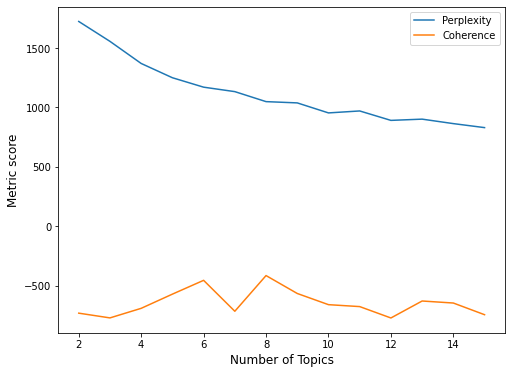

In [84]:
# show graph
limit=16; start=2;
x = range(start, limit)
plt.figure(figsize=(8,6))
plt.plot(x, perplexity_list, label = 'Perplexity')
plt.plot(x, coherence_list[-1][:-1], label = 'Coherence')
plt.xlabel("Number of Topics", fontsize=12)
plt.ylabel("Metric score", fontsize=12)
plt.legend(loc='best')
plt.show()

### Investigate into the negative coherence value:
According to [Bitermplus documentation](https://bitermplus.readthedocs.io/en/latest/benchmarks.html): the coherence metric is calacuted by `u-mass` instead of `c_v` as in the previos LDA model. Therefore the obervation of negative value is normal. 

The best number of topics from BTM would be 8 where the distance between coherence and perplexity is sufficiently small. 

In [48]:
btm_model = btm.BTM(X, vocabulary, seed=12321, T=6, M=20)
btm_model.fit(biterms, iterations=20)
p_zd = btm_model.transform(docs_vec)

100%|██████████| 220583/220583 [00:02<00:00, 84086.04it/s]


In [69]:
topics_coords = tmp.prepare_coords(btm_model)
topics_coords.head()

x           y  topic       size  label
0 -185.986954    2.747591      0   5.110217      0
1  227.199631  142.442215      1  19.401201      1
2 -108.961067 -196.512024      2   5.056701      2
3    9.699583  114.053482      3   7.856390      3
4   72.426270  308.269989      4   6.821872      4

In [70]:
tmp.plot_scatter_topics(topics_coords, size_col='size', label_col='label')

alt.LayerChart(...)

In [50]:
import tmplot as tmp

In [51]:
topics_coords = tmp.prepare_coords(btm_model)
topics_coords.head()

x           y  topic       size  label
0   8.916103  -25.346968      0  16.193715      0
1 -37.128235  -89.809845      1  25.444966      1
2  85.092583 -128.434479      2   4.540086      2
3  30.257559  -89.265862      3  13.755078      3
4   9.950572 -153.520905      4  17.226455      4

In [52]:
tmp.plot_scatter_topics(topics_coords, size_col='size', label_col='label')

alt.LayerChart(...)

In [53]:
phi = tmp.get_phi(btm_model)
terms_probs = tmp.calc_terms_probs_ratio(phi, topic=0, lambda_=1)
tmp.plot_terms(terms_probs)

alt.Chart(...)

In [54]:
phi = tmp.get_phi(btm_model)
terms_probs = tmp.calc_terms_probs_ratio(phi, topic=1, lambda_=1)
tmp.plot_terms(terms_probs)

alt.Chart(...)

In [55]:
phi = tmp.get_phi(btm_model)
terms_probs = tmp.calc_terms_probs_ratio(phi, topic=2, lambda_=1)
tmp.plot_terms(terms_probs)

alt.Chart(...)

In [56]:
phi = tmp.get_phi(btm_model)
terms_probs = tmp.calc_terms_probs_ratio(phi, topic=3, lambda_=1)
tmp.plot_terms(terms_probs)

alt.Chart(...)

In [57]:
phi = tmp.get_phi(btm_model)
terms_probs = tmp.calc_terms_probs_ratio(phi, topic=4, lambda_=1)
tmp.plot_terms(terms_probs)

alt.Chart(...)

### The interactive report plot only works on Google Colab

In [ ]:
tmp.report(btm_model, docs=texts, height=400, width=250)

The best model would be the NMF (Non-negative Matrix Factorization) with 10 topics, based on both topic coherence and overlap metrics and the topics interpretability. 
Although the model produced by LDA has lower topic dimensions, its topic interpretability is compromised as well, for example topic 5 makes no sense. On the contrary, each topic by NMF model can be understood by human and verified by news stories. More importantly, every one type of vaccine is grouped into one topic instead of being clustered together in low dimension models, which showcases its excellent model performance. 

## Exploratory Analysis on the Best Model 

### Dominant topic in each tweet

In [99]:
def format_topics_sentences(topicmodel, corpus=corpus, texts=text):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(topicmodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = topicmodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

## NMF 10-topic model result

In [100]:
text = df.text.values.tolist()
df_topic_sents_keywords = format_topics_sentences(topicmodel=best_model_nmf2, corpus=corpus, texts=text)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index(drop=True)
df_dominant_topic.columns = ['Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

Dominant_Topic  Topic_Perc_Contrib  \
0             9.0              0.7608   
1             6.0              0.9929   
2             4.0              0.4237   
3             2.0              0.5477   
4             9.0              0.9289   
5             2.0              0.3215   
6             6.0              0.9876   
7             2.0              0.5676   
8             1.0              0.5778   
9             1.0              0.5912   

                                                                                    Keywords  \
0  pfizer, covishield, us, biontech, pfizervaccine, study, effective, fda, coronavirus, mrna   
1                vaccination, covishield, today, india, drive, do, centre, start, center, nd   
2                        moderna, shoot, second, mrna, booster, im, vaccinate, nd, feel, one   
3                          people, vaccinate, take, one, sinovac, fully, many, die, like, go   
4  pfizer, covishield, us, biontech, pfizervaccine, study, effective, fda, coronavirus, mrna   
5                          people, vaccinate, take, one, sinovac, fully, many, die, like, go   
6                vaccination, covishield, today, india, drive, do, centre, start, center, nd   
7                          people, vaccinate, take, one, sinovac, fully, many, die, like, go   
8                                  get, vaccinate, today, shoot, second, nd, im, jab, st, go   
9                                  get, vaccinate, today, shoot, second, nd, im, jab, st, go   

                                                                                                                                             Text  
0                                               Same folks said daikon paste could treat a cytokine storm #PfizerBioNTech https://t.co/xeHhIMg1kF  
1    While the world has been on the wrong side of history this year, hopefully, the biggest vaccination effort we've ev… https://t.co/dlCHrZjkhm  
2    #coronavirus #SputnikV #AstraZeneca #PfizerBioNTech #Moderna #Covid_19 Russian vaccine is created to last 2-4 years… https://t.co/ieYlCKBr8P  
3    Facts are immutable, Senator, even when you're not ethically sturdy enough to acknowledge them. (1) You were born i… https://t.co/jqgV18kch4  
4         Explain to me again why we need a vaccine @BorisJohnson @MattHancock #whereareallthesickpeople #PfizerBioNTech… https://t.co/KxbSRoBEHq  
5                Does anyone have any useful advice/guidance for whether the COVID vaccine is safe whilst breastfeeding?… https://t.co/EifsyQoeKN  
6     it is a bit sad to claim the fame for success of #vaccination on patriotic competition between USA, Canada, UK and… https://t.co/IfMrAyGyTP  
7     There have not been many bright days in 2020 but here are some of the best \n1. #BidenHarris winning #Election2020… https://t.co/77u4f8XXfx  
8                                                              Covid vaccine; You getting it?\n\n #CovidVaccine #covid19 #PfizerBioNTech #Moderna  
9  #CovidVaccine \n\nStates will start getting #COVID19Vaccine Monday, #US says \n#pakustv #NYC #Healthcare #GlobalGoals… https://t.co/MksOvBvs5w

### Trendy topics in the COVID19 Vaccine Tweets

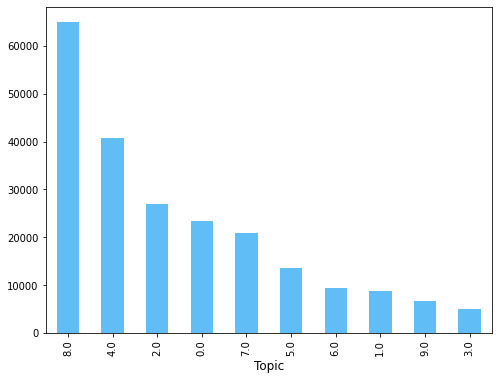

In [126]:
plt.figure(figsize=(8,6))
df_dominant_topic['Dominant_Topic'].value_counts().plot(kind="bar", color='#1DA1F2', alpha=0.7)
plt.xlabel('Topic', fontsize=12)
plt.show()

### Top tweet from each topic

In [127]:
top_tweet_by_topic = df_dominant_topic.sort_values(['Dominant_Topic'],ascending=False).groupby('Dominant_Topic').head(1)
top_tweet_by_topic

Dominant_Topic  Topic_Perc_Contrib  \
0                  9.0              0.7608   
140569             8.0              1.0000   
157021             7.0              0.8485   
160874             6.0              0.2742   
220187             5.0              0.9141   
49413              4.0              0.2850   
54914              3.0              0.3216   
219016             2.0              0.4709   
100689             1.0              0.4948   
75961              0.0              1.0000   
220273             NaN                 NaN   

                                                                                         Keywords  \
0       pfizer, covishield, us, biontech, pfizervaccine, study, effective, fda, coronavirus, mrna   
140569                  covaxin, age, bbmp, rs, hospital, pincode, date, fee, ocgn, bharatbiotech   
157021         receive, sinopharm, sinovac, today, thank, health, vaccinate, good, man, died_days   
160874                vaccination, covishield, today, india, drive, do, centre, start, center, nd   
220187                dose, free, covishield, availability, pincode, date, fee, pm, bengaluru, nd   
49413                         moderna, shoot, second, mrna, booster, im, vaccinate, nd, feel, one   
54914                     first, shoot, sinovac, coronavirus, take, jab, do, sputnik, batch, dose   
219016                          people, vaccinate, take, one, sinovac, fully, many, die, like, go   
100689                                  get, vaccinate, today, shoot, second, nd, im, jab, st, go   
75961     sputnik, india, say, vaccinate, approve, russia, russian, russias, emergency, available   
220273                                                                                        NaN   

                                                                                                                                                   Text  
0                                                     Same folks said daikon paste could treat a cytokine storm #PfizerBioNTech https://t.co/xeHhIMg1kF  
140569                                           560078, \nAGE 45+\n74-D1, 66-D2 slots,\n#COVAXIN on 24-07-2021\n@ ASTER CLINIC - COVAXIN(1410Rs) #BBMP  
157021   #IND #LargestVaccinationDrive has reached a Mile stone of 50 Crore #CovidVaccine doses.\n\nCongrats🥳 to COVID warrior… https://t.co/fAXRgTRUck  
160874                                               Sputnik V to be locally refilled in Karachi\n#Vaccine #SputnikV #Russian \nhttps://t.co/OkhCR4mI6T  
220187    @TraderJK7 @warobusiness I just made 2nd vaccine of #SputnikV \nHonestly, i don't undertand why people in 2021 still… https://t.co/8ObZSTTOgc  
49413       Great overview by @DrEstherFreeman et al on skin rxns after #Moderna and #Pfizer 💉 Bottom line: ok to get that 2nd… https://t.co/CHPHceGSyb  
54914    Prime Minister Narendra Modi takes his second dose of #COVID19 vaccine at AIIMS Delhi today.\n\nHe received the first… https://t.co/KdxVNAj73d  
219016    🔲 Your World This Week | Weekly round-up of all the top news stories of the week\n\nPresented by: \n@isaurabhshukla,… https://t.co/B19xKm0wMi  
100689        Vaccinated finally!!! 🙌🏼🇵🇰\nGet you vaccine STOP COVID-19\n\n #Sinopharm #COVID19 #covidvacccinedone #Vaccinated… https://t.co/H6PJvJpPWs  
75961              | COVID 19 VACCINE | FAQs| 5 MINUTES | Everything you should know. 💉  #covaxin #covishield #pfizer #moderna… https://t.co/2T30mrT8PN  
220273  18-44 #URBAN #Bengaluru #CovidVaccine Availability for 11/11 at 09:00AM\nFREE Slots 0\nPAID Slots \n#COVISHIELD - Dose… https://t.co/RprfgTiVK3